Import the Dependencies


In [3]:
import pandas as pd
import logging
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

# Logging Setup for better monitoring
logging.basicConfig(level=logging.INFO)

Data Collections

Healthcare dataset-stroke-data

In [22]:
class DataLoader:
    """Handles loading data from a CSV file."""

    def __init__(self, file_path: str):
        self.file_path = file_path

    def load_data(self) -> pd.DataFrame:
        """
        Reads the data from the specified CSV file.

        Returns:
            pd.DataFrame: The dataset as a DataFrame.
        """
        data = pd.read_csv(self.file_path)
        logging.info(f"Loaded data from {self.file_path} with {data.shape[0]} rows and {data.shape[1]} columns.")
        return data


Dataset Inspection Class

In [23]:
class DataInspector:
    """Helps to explore and understand a dataset."""

    def __init__(self, name="Dataset"):
        self.name = name

    def display_info(self, data: pd.DataFrame):
        """Show basic details about the dataset's structure."""
        print(f"\n{self.name} Info:")
        print(data.info())

    def display_head(self, data: pd.DataFrame, n=5):
        """Show the first few rows of the dataset (default is 5)."""
        print(f"\n{self.name} - First {n} Rows:")
        print(data.head(n))

    def display_missing_values(self, data: pd.DataFrame):
        """Show how many missing values are in each column."""
        print(f"\n{self.name} - Missing Values:")
        print(data.isnull().sum())

    def display_summary_statistics(self, data: pd.DataFrame):
        """Show summary statistics (like mean, median) for numerical columns."""
        print(f"\n{self.name} - Summary Statistics:")
        print(data.describe())

    def display_shape(self, data: pd.DataFrame):
        """Show the number of rows and columns in the dataset."""
        print(f"\n{self.name} - Shape: {data.shape[0]} rows, {data.shape[1]} columns")

    def inspect_all(self, data: pd.DataFrame, n=5):
        """Show all details for a quick overview of the dataset."""
        self.display_info(data)
        self.display_shape(data)
        self.display_head(data, n=n)
        self.display_missing_values(data)
        self.display_summary_statistics(data)



Dataset Visualizer Class

In [13]:
class DataVisualizer:
    """Helps create visual charts and graphs to understand data better."""

    @staticmethod
    def plot_distribution(data: pd.DataFrame, column: str):
        """Show how the values of a column are spread out."""
        plt.figure(figsize=(8, 6))
        sns.histplot(data[column], kde=True)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

    @staticmethod
    def correlation_heatmap(data: pd.DataFrame):
        """Show how different features in the data relate to each other."""
        plt.figure(figsize=(10, 8))
        sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
        plt.title('Feature Correlation Heatmap')
        plt.show()

    @staticmethod
    def plot_pie_chart(data: pd.DataFrame, column: str, labels: list):
        """Show a pie chart to see the proportion of different categories in a column."""
        plt.figure(figsize=(8, 6))
        data_counts = data[column].value_counts()
        plt.pie(data_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
        plt.title(f'Proportion of {column}')
        plt.axis('equal')  # Ensures the pie is a circle.
        plt.show()

    @staticmethod
    def plot_box(data: pd.DataFrame, column: str, target: str):
        """Show a box plot to compare values in a column based on another variable."""
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=target, y=column, data=data)
        plt.title(f'{column} by {target}')
        plt.xlabel(target)
        plt.ylabel(column)
        plt.show()

    @staticmethod
    def plot_count(data: pd.DataFrame, column: str, target: str):
        """Show how often each category appears in a column, split by another variable."""
        plt.figure(figsize=(8, 6))
        sns.countplot(x=column, hue=target, data=data)
        plt.title(f'Count of {column} by {target}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.show()


Dataset Preprocessor Class

In [14]:
import pandas as pd
import numpy as np
import logging
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

class DataPreprocessor:
    def __init__(self):
        """
        Initialize the DataPreprocessor with a scaler and label encoder.
        """
        self.scaler = StandardScaler()  # StandardScaler to normalize feature values.
        self.label_encoder = LabelEncoder()  # LabelEncoder for categorical variable encoding.

    def fill_numeric_missing_values(self, data: pd.DataFrame):
        """
        Fill missing values in numeric columns with the mean of each column.

        :param data: DataFrame containing the dataset.
        """
        numeric_columns = data.select_dtypes(include=[np.number]).columns
        # Fill missing values for numeric columns with their mean
        data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())
        logging.info("Filled missing values for numeric columns with their mean.")

    def encode_categorical_features(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Encode categorical columns using label encoding and one-hot encoding.

        :param data: DataFrame containing the dataset.
        :return: DataFrame with encoded categorical columns.
        """
        # Identify categorical columns
        categorical_columns = data.select_dtypes(include=['object']).columns
        for column in categorical_columns:
            # Apply label encoding
            data[column] = self.label_encoder.fit_transform(data[column].astype(str))
        # Convert any remaining categorical columns to one-hot encoding
        data = pd.get_dummies(data, drop_first=True)
        logging.info("Successfully encoded categorical columns.")
        return data

    def preprocess_data(self, data: pd.DataFrame):
        """
        Preprocess the dataset by handling missing values, encoding categorical features,
        and scaling numerical features.

        :param data: DataFrame containing the dataset.
        :return: Tuple of training and testing feature sets and target variable sets.
        :raises ValueError: If the target variable is not found in the dataset.
        """
        # Step 1: Handle missing values
        self.fill_numeric_missing_values(data)

        # Step 2: Encode categorical columns
        data = self.encode_categorical_features(data)

        # Step 3: Verify presence of the target variable and split features and target
        if 'stroke' not in data.columns:
            raise ValueError("Target variable 'stroke' not found in the dataset.")
        features = data.drop(columns=['stroke'])
        target = data['stroke']

        # Step 4: Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)
        logging.info("Split the data into training and testing sets.")

        # Step 5: Scale the feature sets
        X_train = self.scaler.fit_transform(X_train)
        X_test = self.scaler.transform(X_test)
        logging.info("Scaled the features to standardize the dataset.")

        return X_train, X_test, y_train, y_test

Feature Extrator Class

In [15]:
class DataFeatureExtractor:
    def __init__(self, top_k: int):
        """
        Initialize the FeatureExtractor with the number of top features to select.

        :param top_k: Number of top features to retain during selection.
        """
        self.top_k = top_k
        self.scaler = MinMaxScaler()  # Initialize the MinMaxScaler for normalization.

    def extract_top_features(self, X_train, y_train):
        """
        Extract the top k features based on the chi-squared test.

        :param X_train: Training feature dataset.
        :param y_train: Training target labels.
        :return: Transformed feature dataset with selected top k features and the selector object.
        """
        # Scale the training data to ensure non-negative values for chi-squared computation.
        X_train_scaled = self.scaler.fit_transform(X_train)

        # Use SelectKBest with chi-squared to select the top k features.
        feature_selector = SelectKBest(chi2, k=self.top_k)
        selected_features = feature_selector.fit_transform(X_train_scaled, y_train)
        return selected_features, feature_selector

Stroke Risk Prediction Class

In [16]:

class DataStrokeRiskPredictor:
    def __init__(self):
        """
        Initialize the StrokeRiskPredictor with various models.
        """
        self.model_candidates = {
            'Logistic Regression': LogisticRegression(max_iter=1000),
            'Random Forest': RandomForestClassifier(),
            'Support Vector Machine': SVC(),
            'K-Nearest Neighbors': KNeighborsClassifier(),
            'Decision Tree': DecisionTreeClassifier(),
            'Gradient Boosting': GradientBoostingClassifier(),
            'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
        }
        self.selected_model = None  # To store the best-performing model.

    def train_all_models(self, X_train, y_train):
        """
        Train all candidate models on the training data.

        :param X_train: Training feature dataset.
        :param y_train: Training target labels.
        """
        for model_name, model in self.model_candidates.items():
            model.fit(X_train, y_train)
            print(f"{model_name} has been trained successfully.")

    def evaluate_model_performance(self, X_test, y_test):
        """
        Evaluate the performance of all trained models and determine the best one.

        :param X_test: Testing feature dataset.
        :param y_test: Testing target labels.
        :return: The best-performing model based on accuracy.
        """
        best_accuracy = 0
        for model_name, model in self.model_candidates.items():
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            print(f"{model_name} Accuracy: {accuracy:.4f}")
            print(classification_report(y_test, y_pred))

            # Update the best model if the current one has a higher accuracy.
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                self.selected_model = model

        print(f"The best model is: {type(self.selected_model).__name__} with an accuracy of: {best_accuracy:.4f}")
        return self.selected_model

    def make_prediction(self, X):
        """
        Use the best trained model to make predictions on new data.

        :param X: New input data for prediction.
        :return: Predicted labels based on the best model.
        :raises ValueError: If no model has been trained.
        """
        if self.selected_model:
            return self.selected_model.predict(X)
        else:
            raise ValueError("No trained model found. Please train the models first.")

STEP 2 DATA INSPECTIONS

Stroke Prediction Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None

Stroke Prediction Dataset Shape: 5110 rows, 12 columns

Stroke Prediction Dataset First 5 Rows

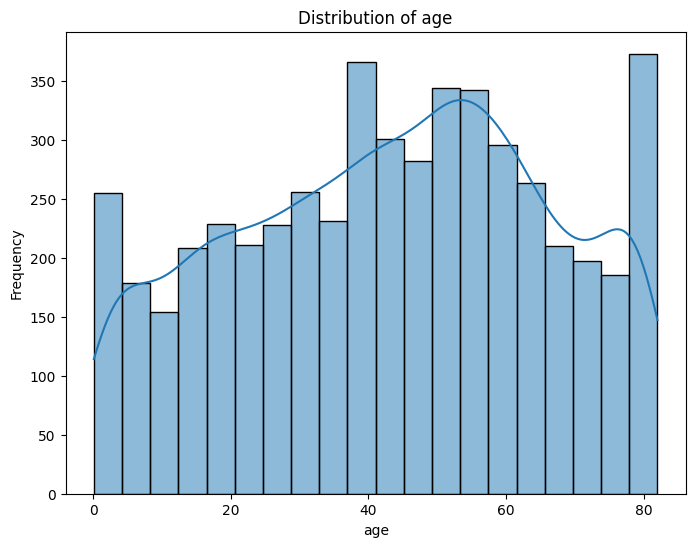

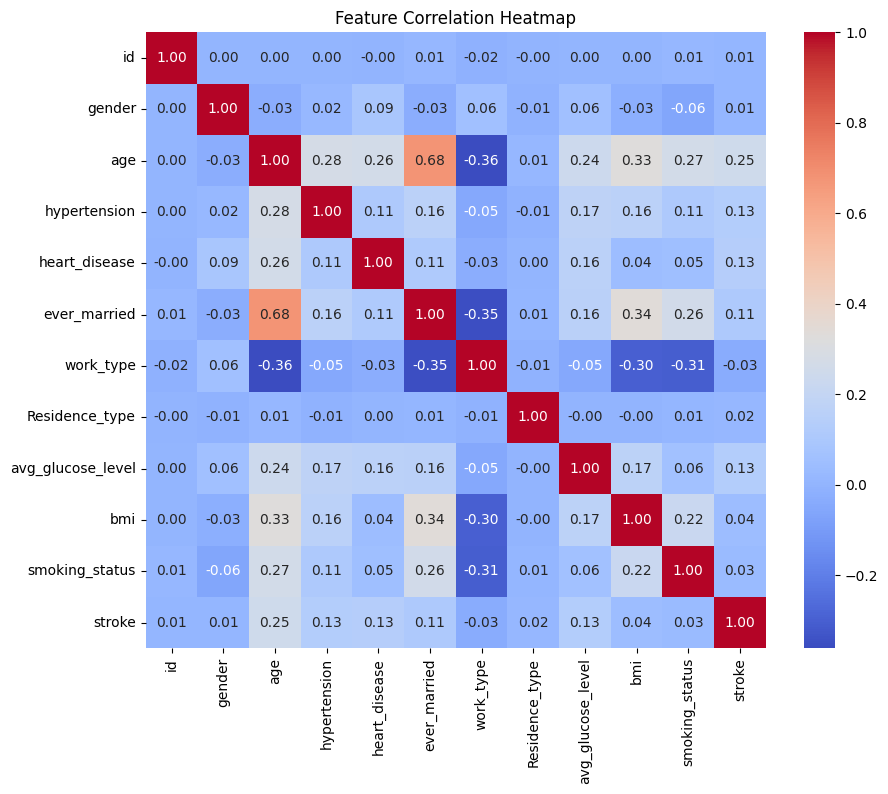

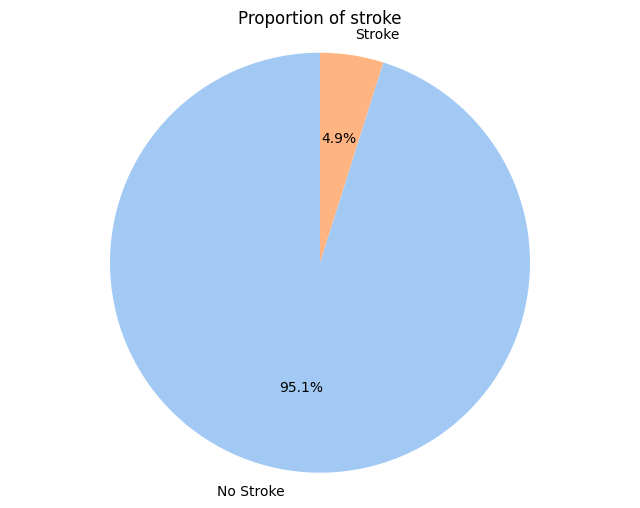

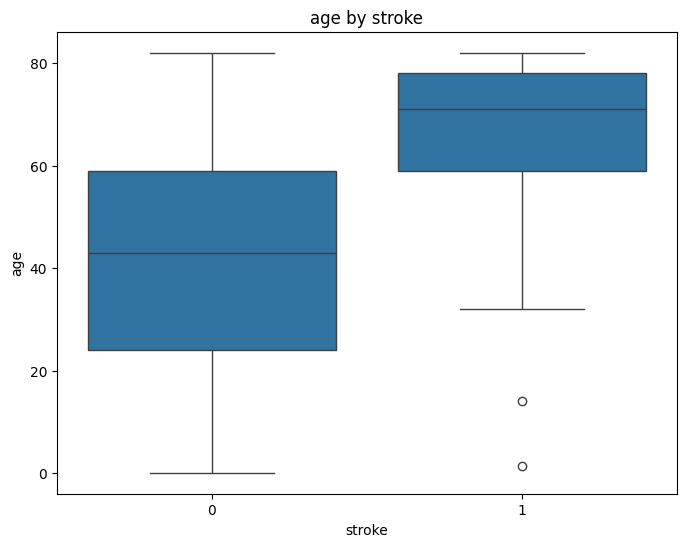

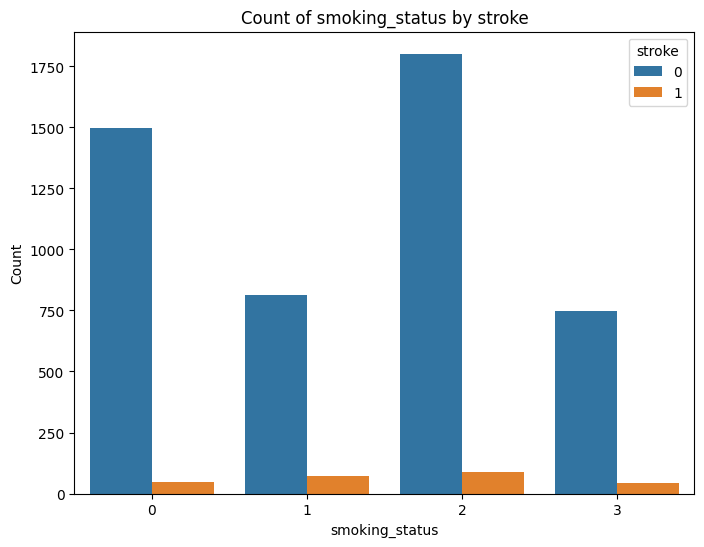

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=2000 is greater than n_features=11. All the features will be returned.
  warnings.warn(


STEP 6  MODEL TRAINING AND EVALUATION
Logistic Regression has been trained successfully.
Random Forest has been trained successfully.
Support Vector Machine has been trained successfully.
K-Nearest Neighbors has been trained successfully.
Decision Tree has been trained successfully.
Gradient Boosting has been trained successfully.


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost has been trained successfully.
Logistic Regression Accuracy: 0.8774
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      1444
           1       0.24      0.51      0.32        89

    accuracy                           0.88      1533
   macro avg       0.60      0.70      0.63      1533
weighted avg       0.92      0.88      0.90      1533

Random Forest Accuracy: 0.9393
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1444
           1       0.25      0.02      0.04        89

    accuracy                           0.94      1533
   macro avg       0.60      0.51      0.50      1533
weighted avg       0.90      0.94      0.91      1533

Support Vector Machine Accuracy: 0.9419
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1444
           1       0.00      0.00      0.00        89

    accuracy                       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K-Nearest Neighbors Accuracy: 0.9393
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1444
           1       0.00      0.00      0.00        89

    accuracy                           0.94      1533
   macro avg       0.47      0.50      0.48      1533
weighted avg       0.89      0.94      0.91      1533

Decision Tree Accuracy: 0.8082
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      1444
           1       0.11      0.34      0.17        89

    accuracy                           0.81      1533
   macro avg       0.53      0.59      0.53      1533
weighted avg       0.90      0.81      0.85      1533

Gradient Boosting Accuracy: 0.8878
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1444
           1       0.15      0.20      0.17        89

    accuracy                           0.89      1533
   macro avg       0.55  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
class Main:
  # Step 1: Data Collection
  # https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset
  collector = DataLoader('/content/stroke_data.csv')
  data = collector.load_data()

  # Step 2: Data Inspectior
  print('STEP 2 DATA INSPECTIONS')
  selected_inspector = DataInspector(name="Stroke Prediction Dataset")
  selected_inspector.inspect_all(data)

  # Step 3: Data Preprocessing
  print('STEP 3 DATA PREPROCESSING')
  preprocessor = DataPreprocessor()
  X_train, X_test, y_train, y_test = preprocessor.preprocess_data(data)
  selected_inspector.inspect_all(data)

  # Step 4: Data Visualization
  print('STEP 4 DATA VISUALIZATION')
  DataVisualizer.plot_distribution(data, 'age')
  DataVisualizer.correlation_heatmap(data)
  # Pie chart for stroke vs. no stroke
  DataVisualizer.plot_pie_chart(data, column='stroke', labels=['No Stroke', 'Stroke'])
  # Box plot comparing 'age' for stroke and no stroke cases
  DataVisualizer.plot_box(data, column='age', target='stroke')
  # Count plot of smoking status split by stroke cases
  DataVisualizer.plot_count(data, column='smoking_status', target='stroke')

  # Step 5: Feature Selection
  feature_selector = DataFeatureExtractor(top_k=2000)
  X_train_selected, selector = feature_selector.extract_top_features(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  # Step 6: Model Training and Evaluation
  print('STEP 6  MODEL TRAINING AND EVALUATION')
  predictor = DataStrokeRiskPredictor()
  predictor.train_all_models(X_train_selected, y_train)
  best_model = predictor.evaluate_model_performance(X_test_selected, y_test)

  # Step 7: Prediction
  print('STEP 7 MODEL PREDICTIONS')
  sample_data = X_test_selected[:10]
  predictions = predictor.make_prediction(sample_data)
  print(f"Predictions for the sample data: {predictions}")